In [1]:
import re
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from random import randint
from matplotlib.ticker import MaxNLocator
from functools import partial
import pickle

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot  as plt
from scipy import sparse

import nltk
from nltk.stem import PorterStemmer 
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import data_lake_helper as dl_helper

In [2]:
data_lake = dl_helper.DataLake(version='v3')

In [2]:
#setting up dataframe 

df_train_table = pd.read_csv('dataset/train_set.csv')
df_train_table.index = df_train_table.pk_id
df_train_table['path'] = 'dataset/train_set/'
del df_train_table['pk_id']

df_test_table = pd.read_csv('dataset/test_set.csv')
df_test_table.index = df_test_table.pk_id
df_test_table['path'] = 'dataset/test_set/'
del df_test_table['pk_id']

df_ = df_train_table.append(df_test_table, sort=False)

del df['master_tree']

In [ ]:
file_extension = '.txt'
texts = []
for i in range(0,len(df_)):
    item = df.iloc[i]
    pk_id = str(item.name)
    text = open(item.path + pk_id + file_extension).read()
    texts.append(text)
    
df['text_r'] = texts

In [ ]:
df_cat_dummy = pd.DataFrame()
df_cat_dummy['file_type'] = np.zeros(len(df_.category.unique()))
df_cat_dummy.index = df_.category.unique()
df_cat_dummy

colors = []
for i in range(len(df_.category.unique())):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

In [ ]:
def graph(filter_key, group_key, sort_key_value='category', 
          ylim_value=None, use_dummy_df=True, graph_colors=None,
          xlabel_value='', ylabel_value='', show_bar_values=False, maxnlocator=None):
    
    global colors
    
    for i, filter_key_value in enumerate(df_[filter_key].unique()):
        _ = plt.figure(i)

        df_filtered = df_[df_[filter_key] == filter_key_value]
        df_grouped = df_filtered.groupby(group_key).count()

        if use_dummy_df:
            #agrego categories que no estan 
            for i in range(0, len(df_cat_dummy)):
                item = df_cat_dummy.iloc[i]
                if item.name not in df_grouped.index:
                    df_grouped = df_grouped.append(item)

        df_grouped.sort_values(by=[sort_key_value], inplace=True)

        y = df_grouped.file_type
        x = df_grouped.index
        
        if ylim_value is not None:
            plt.ylim(0, ylim_value)

        if maxnlocator is not None:
            ax = plt.figure().gca()
            ax.xaxis.set_major_locator(MaxNLocator(integer=maxnlocator))

        colors_list = []
        if graph_colors is None:
            colors_list = colors
        else:
            colors_list = graph_colors
        
        plt.bar(x, y, color=colors_list, tick_label=x)    
        plt.xlabel(xlabel_value)
        plt.ylabel(ylabel_value)
        plt.title(filter_key_value)
        
        if show_bar_values:
            total = df_grouped.file_type.sum()
            df_grouped['percentage'] = round(df_grouped.file_type / total * 100, 2)
            
            xlocs, xlabs = plt.xticks()
            for i, v in enumerate(y):
                y_value = df_grouped.percentage.iloc[i]
                plt.text(xlocs[i] - 0.5, v + 100, str(y_value)+'%')

    plt.show()

In [196]:
# Most/Less freq words on corpus
################################

try:
    all_freq_words = data_lake.load_obj('all_freq_words.pkl')

except:
    all_words = []

    for i in range(0,len(df_)):
        item = df_.iloc[i]
        all_words += word_tokenize(item.text_r)

    all_freq_words = nltk.FreqDist(w.lower() for w in all_words)

    data_lake.save_obj(all_freq_words, 'all_freq_words.pkl')


In [206]:
def get_document_features(document, word_features):
    document_words = set(word_tokenize(document))
    #features = {}
    features_count = 0
    
    for word in word_features:
        #features['contains({})'.format(word)] = (word in document_words)
        if word in document_words:
            features_count += 1
    
    return features_count

In [205]:
most_freq_words = list(all_freq_words)[:10]# -> PARAMETER TO IMPROVE
less_freq_words = list(all_freq_words)[-10:]# -> PARAMETER TO IMPROVE


In [207]:
most_freq_words_count = []
for i in range(0,len(df_)):
    item = df_.iloc[i]
    most_freq_words_count.append(get_document_features(item.text_r, most_freq_words))
    
df_['most_freq_words_count'] = most_freq_words_count

#################

less_freq_words_count = []
for i in range(0,len(df_)):
    item = df_.iloc[i]
    less_freq_words_count.append(get_document_features(item.text_r, less_freq_words))
    
df_['less_freq_words_count'] = less_freq_words_count

<Figure size 432x288 with 0 Axes>

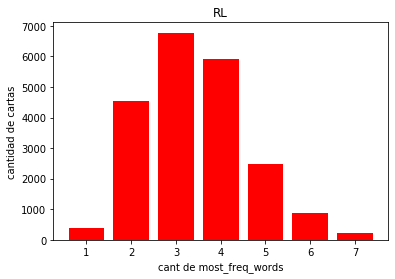

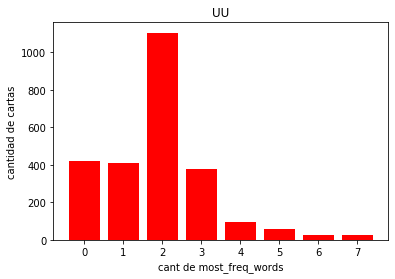

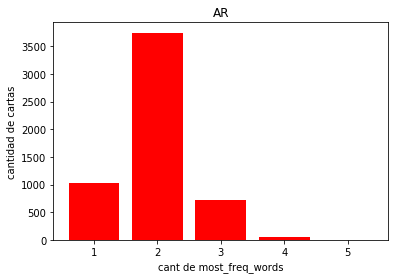

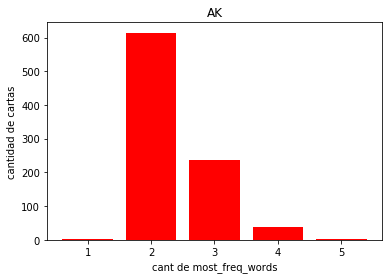

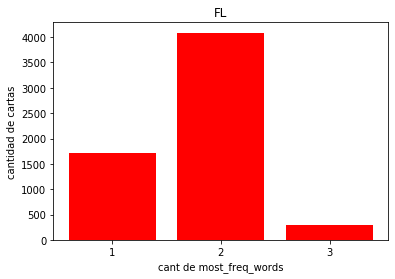

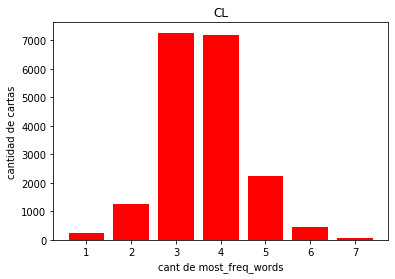

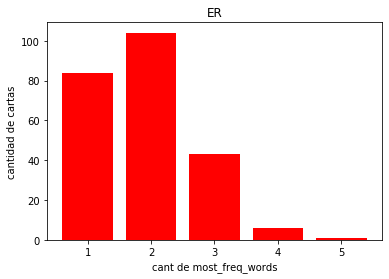

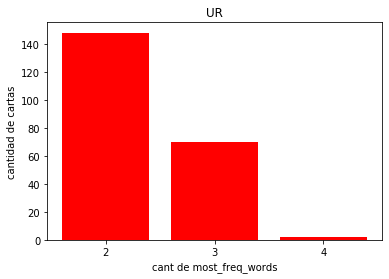

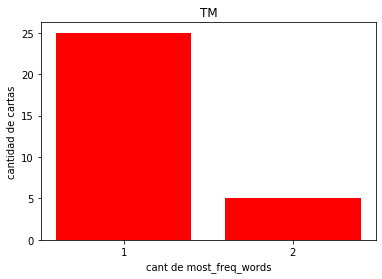

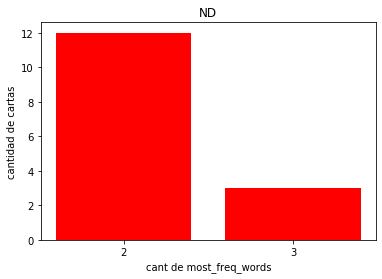

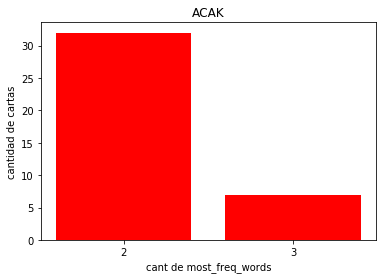

In [226]:
graph(filter_key='category', group_key='most_freq_words_count', sort_key_value='most_freq_words_count',
      maxnlocator = True, use_dummy_df=False, graph_colors=['red'], show_bar_values=False,
      xlabel_value='cant de most_freq_words', ylabel_value='cantidad de cartas')

<Figure size 432x288 with 0 Axes>

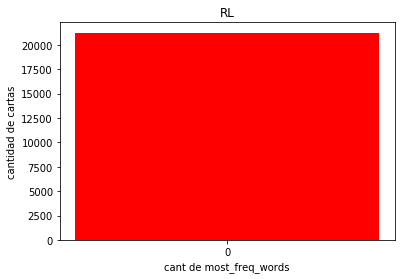

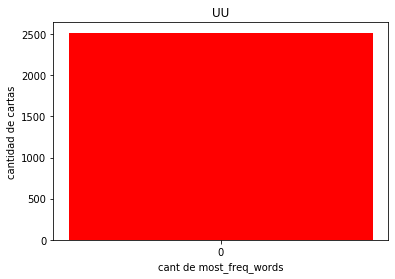

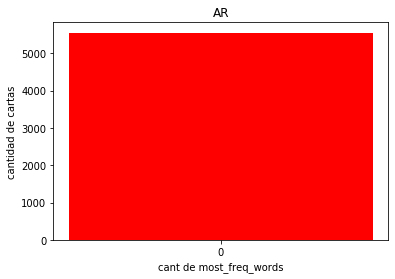

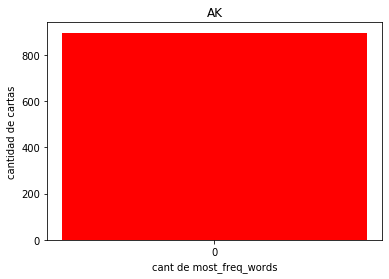

KeyboardInterrupt: 

In [227]:
graph(filter_key='category', group_key='less_freq_words_count', sort_key_value='less_freq_words_count',
      maxnlocator = True, use_dummy_df=False, graph_colors=['red'], show_bar_values=False,
      xlabel_value='cant de less_freq_words', ylabel_value='cantidad de cartas')

In [215]:
# Most/Less freq bigrams on corpus
################################

try:
    all_freq_bgs = data_lake.load_obj('all_freq_bgs.pkl')
    
except:
    all_bgs = []
    
    for i in range(0,len(df_)):
        item = df_.iloc[i]
        tokens = word_tokenize(item.text_r)
        bgs = nltk.bigrams(tokens)
        all_bgs += bgs

    all_freq_bgs = nltk.FreqDist((w1.lower(), w2.lower()) for (w1,w2) in all_bgs)

    data_lake.save_obj(all_freq_bgs, 'all_freq_bgs.pkl')

AttributeError: 'tuple' object has no attribute 'lower'

In [218]:
def get_doc_bgs(document, bgs_features):
    tokens = word_tokenize(document)
    bgs = nltk.bigrams(tokens)
    document_bgs = set(bgs)
    
    features_count = 0
    
    for word in bgs_features:
        if word in document_bgs:
            features_count += 1
    
    return features_count

In [220]:
most_freq_bgs = list(all_freq_bgs)[:20]# -> PARAMETER TO IMPROVE
less_freq_bgs = list(all_freq_bgs)[-20:]# -> PARAMETER TO IMPROVE

In [221]:
most_freq_bgs_count = []
for i in range(0,len(df_)):
    item = df_.iloc[i]
    most_freq_bgs_count.append(get_doc_bgs(item.text_r, most_freq_bgs))
    
df_['most_freq_bgs_count'] = most_freq_bgs_count

#################

less_freq_bgs_count = []
for i in range(0,len(df_)):
    item = df_.iloc[i]
    less_freq_bgs_count.append(get_doc_bgs(item.text_r, less_freq_bgs))
    
df_['less_freq_bgs_count'] = less_freq_bgs_count

<Figure size 432x288 with 0 Axes>

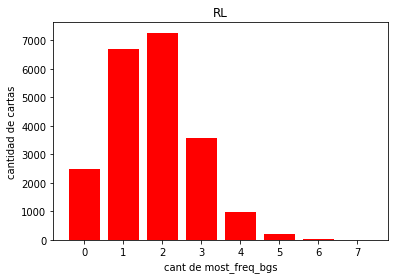

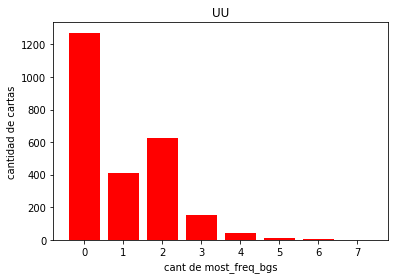

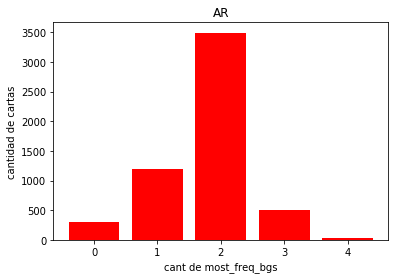

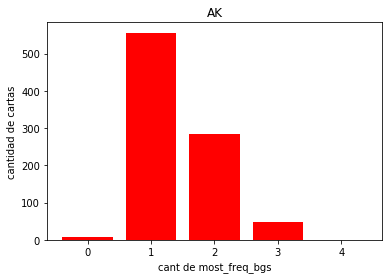

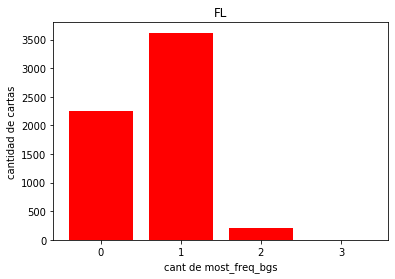

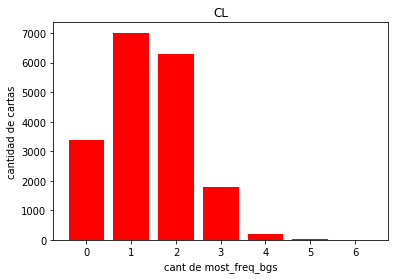

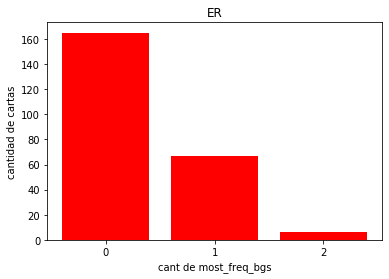

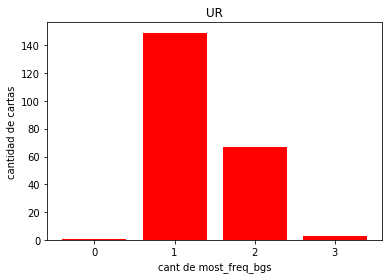

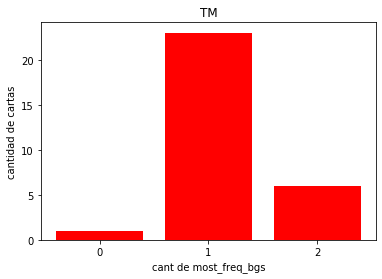

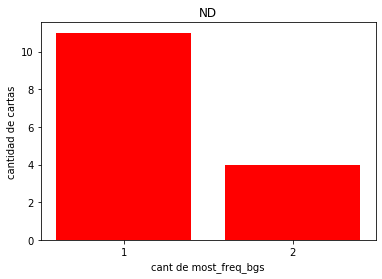

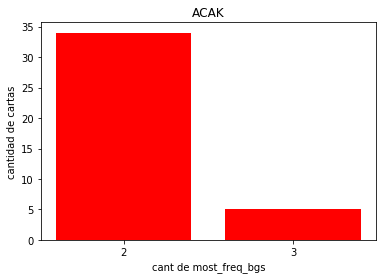

In [230]:
graph(filter_key='category', group_key='most_freq_bgs_count', sort_key_value='most_freq_bgs_count',
      maxnlocator = True, use_dummy_df=False, graph_colors=['red'], show_bar_values=False,
      xlabel_value='cant de most_freq_bgs', ylabel_value='cantidad de cartas')

<Figure size 432x288 with 0 Axes>

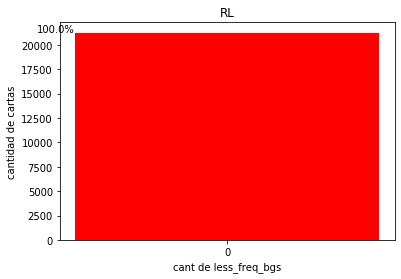

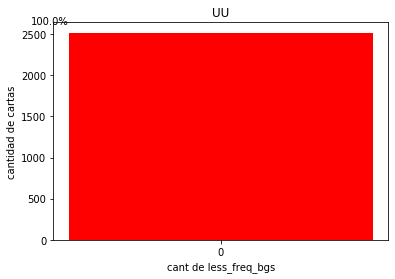

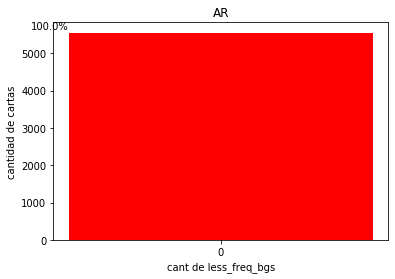

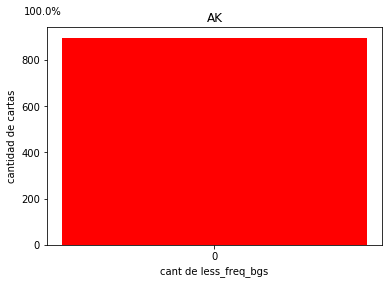

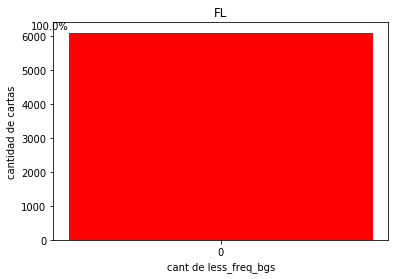

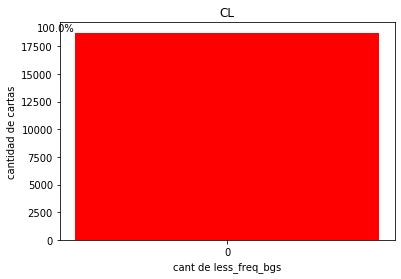

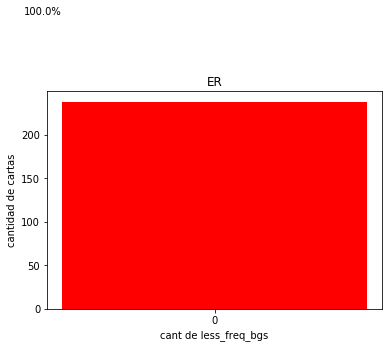

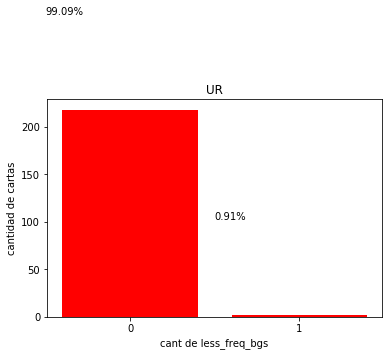

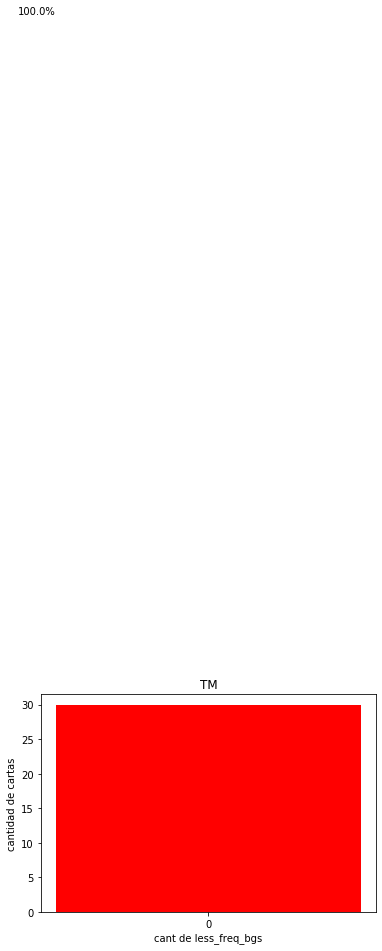

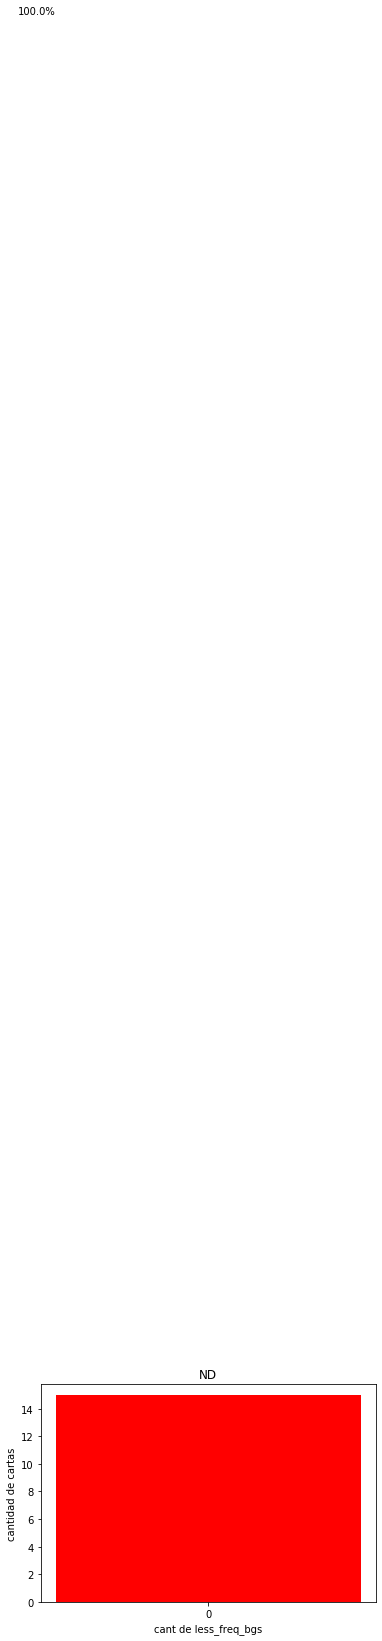

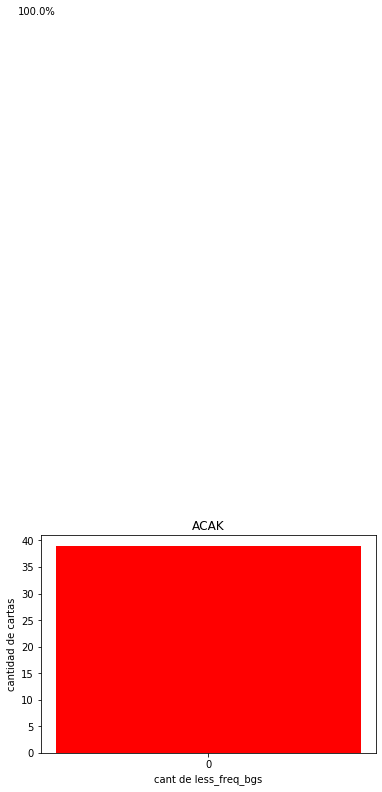

In [229]:
graph(filter_key='category', group_key='less_freq_bgs_count', sort_key_value='less_freq_bgs_count',
      maxnlocator = True, use_dummy_df=False, graph_colors=['red'], show_bar_values=False,
      xlabel_value='cant de less_freq_bgs', ylabel_value='cantidad de cartas')

In [243]:
#Most important n-grams per category
##########################################

already_loaded = True

if not already_loaded:
    
    for c in df_.category.unique():
        df_c = df_[df_.category == c]
        all_bgs = []
        for i in range(0,len(df_c)):
            item = df_c.iloc[i]
            text_r = item.text_r.lower()
            tokens = word_tokenize(text_r)
            bgs = nltk.bigrams(tokens)
            all_bgs += bgs

        all_freq_bgs = nltk.FreqDist(all_bgs)

        data_lake.save_obj(all_freq_bgs, 'all_freq_bgs_' + str(c) + '.pkl')

KeyboardInterrupt: 

In [ ]:
#Most important ACAK n-grams
################################

"""(('defense', 'in'), 39),
 (('in', 'any'), 39),
 (('any', 'proceeding'), 39),
 (('proceeding', 'initiated'), 39),
 (('initiated', 'by'), 39),
 
 (('or', 'any'), 39),
 (('any', 'person'), 39),
 (('person', 'under'), 39),"""

#the above n-grams are in the same sentence, and only 1 time in each ACAK letter

In [311]:
acak_sentence_1 = 'defense in any proceeding initiated by'.lower()
acak_headers = [acak_sentence_1]

look_for_acak_headers = partial(look_for_text_list, acak_headers)
df_['acak_sentence_presence_1'] = map_letters(look_for_acak_headers)

In [312]:
acak_sentence_2 = 'or any person under'.lower()
acak_headers = [acak_sentence_2]

look_for_acak_headers = partial(look_for_text_list, acak_headers)
df_['acak_sentence_presence_2'] = map_letters(look_for_acak_headers)

In [347]:
acak_sentence_3 = 'from taking any action'.lower()
acak_headers = [acak_sentence_3]

look_for_acak_headers = partial(look_for_text_list, acak_headers)
df_['acak_sentence_presence_3'] = map_letters(look_for_acak_headers)

In [375]:
l1 = df_['acak_sentence_presence_1'].tolist()
l2 = df_['acak_sentence_presence_2'].tolist()
l3 = df_['acak_sentence_presence_3'].tolist()

r_list = [v1 and v2 for (v1,v2,v3) in zip(l1, l2, l3)]
df_['acak_sentence_presence_1_2'] = r_list
print(len(list(filter(lambda x: x == True, r_list))))

r_list = [v1 and v3 for (v1,v2,v3) in zip(l1, l2, l3)]
df_['acak_sentence_presence_1_3'] = r_list
print(len(list(filter(lambda x: x == True, r_list))))

r_list = [v1 and v2 and v3 for (v1,v2,v3) in zip(l1, l2, l3)]
df_['acak_sentence_presence_all'] = r_list
print(len(list(filter(lambda x: x == True, r_list))))

print(len(df_[df_.category == 'ACAK']))

22544
20113
19529
39


In [365]:
for c in df_.category.unique():
    df_c = df_[df_.category == c]
    print(c)
    print(df_c.groupby('acak_sentence_presence_all').count().file_type)
    print()

RL
acak_sentence_presence_all
False    11601
True      9645
Name: file_type, dtype: int64

UU
acak_sentence_presence_all
False    2314
True      201
Name: file_type, dtype: int64

AR
acak_sentence_presence_all
False    2552
True     2993
Name: file_type, dtype: int64

AK
acak_sentence_presence_all
False    264
True     631
Name: file_type, dtype: int64

FL
acak_sentence_presence_all
False    6017
True       70
Name: file_type, dtype: int64

CL
acak_sentence_presence_all
False    12765
True      5961
Name: file_type, dtype: int64

ER
acak_sentence_presence_all
False    234
True       4
Name: file_type, dtype: int64

UR
acak_sentence_presence_all
False    220
Name: file_type, dtype: int64

TM
acak_sentence_presence_all
False    30
Name: file_type, dtype: int64

ND
acak_sentence_presence_all
False    15
Name: file_type, dtype: int64

ACAK
acak_sentence_presence_all
False    15
True     24
Name: file_type, dtype: int64



In [355]:
#
# Vamos con sentence_1 es el n-grama mas largo y que se presenta mas veces en ACAK
#

In [380]:
#Most important CL n-grams
################################

all_freq_bgs_c = data_lake.load_obj('all_freq_bgs_' + str('CL') + '.pkl')

In [381]:
len(df_[df_.category == 'CL'])

18726

In [383]:
all_freq_bgs_c.most_common()

[(('of', 'the'), 219036),
 (('.', 'please'), 124698),
 (('in', 'the'), 96344),
 ((',', 'page'), 91026),
 (('to', 'the'), 90540),
 (('for', 'the'), 82379),
 ((',', 'please'), 79393),
 (('we', 'note'), 63602),
 (('our', 'comments'), 63592),
 (('the', 'company'), 63325),
 (('in', 'your'), 60079),
 (('that', 'the'), 58443),
 (('response', 'to'), 57883),
 ((',', 'we'), 55888),
 (('we', 'may'), 55682),
 (('the', 'filing'), 52909),
 (('comments', '.'), 51357),
 (('.', 'in'), 49569),
 (('202', ')'), 49290),
 (('(', '202'), 49287),
 (('at', '('), 48987),
 (('.', 'we'), 48485),
 (('of', 'your'), 48138),
 (('disclosure', 'in'), 47784),
 (('your', 'disclosure'), 46426),
 (('registration', 'statement'), 45188),
 (('tell', 'us'), 44751),
 (('that', 'you'), 44608),
 (('’', 's'), 42502),
 (('your', 'response'), 42209),
 (('please', 'revise'), 40811),
 (('our', 'review'), 40257),
 (('and', 'the'), 38814),
 (('if', 'you'), 38567),
 (('to', 'our'), 37564),
 (('you', 'have'), 37482),
 (('your', 'filing'),

In [387]:
cl_sentence_2 = 'financial statements'.lower()
cl_headers = [cl_sentence_2]

look_for_cl_headers = partial(look_for_text_list, cl_headers)
df_['cl_sentence_presence_2'] = map_letters(look_for_cl_headers)

In [388]:
print(len(list(filter(lambda x: x == True, df_['cl_sentence_presence_2'].tolist()))))
print(len(df_[df_.category == 'CL']))

23919
18726


In [389]:
for c in df_.category.unique():
    df_c = df_[df_.category == c]
    print(c)
    print(df_c.groupby('cl_sentence_presence_2').count().file_type)
    print()

RL
cl_sentence_presence_2
False    10316
True     10930
Name: file_type, dtype: int64

UU
cl_sentence_presence_2
False    1984
True      531
Name: file_type, dtype: int64

AR
cl_sentence_presence_2
False    5490
True       55
Name: file_type, dtype: int64

AK
cl_sentence_presence_2
False    869
True      26
Name: file_type, dtype: int64

FL
cl_sentence_presence_2
False    6057
True       30
Name: file_type, dtype: int64

CL
cl_sentence_presence_2
False     6421
True     12305
Name: file_type, dtype: int64

ER
cl_sentence_presence_2
False    231
True       7
Name: file_type, dtype: int64

UR
cl_sentence_presence_2
False    187
True      33
Name: file_type, dtype: int64

TM
cl_sentence_presence_2
False    28
True      2
Name: file_type, dtype: int64

ND
cl_sentence_presence_2
False    15
Name: file_type, dtype: int64

ACAK
cl_sentence_presence_2
False    39
Name: file_type, dtype: int64



In [392]:
#Most important FL n-grams
################################

all_freq_bgs_c = data_lake.load_obj('all_freq_bgs_' + str('FL') + '.pkl')

In [393]:
len(df_[df_.category == 'FL'])

6087

In [394]:
all_freq_bgs_c.most_common()

[(('for', 'the'), 7356),
 (('no', '.'), 6532),
 (('review', 'of'), 6305),
 (('our', 'review'), 6285),
 (('file', 'no'), 6270),
 (('we', 'have'), 6154),
 (('completed', 'our'), 6084),
 (('re', ':'), 6080),
 (('have', 'completed'), 6064),
 (('sincerely', ','), 6017),
 (('of', 'your'), 6010),
 ((':', 'we'), 5960),
 (('form', '10-k'), 5804),
 (('.', 'sincerely'), 5770),
 ((',', 'inc.'), 5668),
 (('.', 'we'), 5597),
 (('the', 'company'), 5435),
 (('dear', 'mr.'), 5429),
 (('of', 'the'), 5198),
 (('31', ','), 5180),
 (('year', 'ended'), 5132),
 (('the', 'filing'), 4890),
 (('disclosure', 'in'), 4873),
 (('our', 'comments'), 4855),
 (('the', 'commission'), 4834),
 (('fiscal', 'year'), 4058),
 (('10-k', 'for'), 4052),
 (('united', 'states'), 3936),
 (('ended', 'december'), 3935),
 (('december', '31'), 3902),
 (('do', 'not'), 3526),
 (('at', 'this'), 3094),
 (('this', 'time'), 3094),
 (('further', 'comments'), 3089),
 (('financial', 'officer'), 3049),
 (('responsible', 'for'), 3030),
 (('that',

In [395]:
df_[df_.category == 'FL'].head().index

Int64Index([6731316, 13501725, 2337211, 9828303, 12848562], dtype='int64', name='pk_id')

In [396]:
fl_sentences = ['branch chief', 'chief financial', 'financial officer', '10-k for', 'form 10-k']

for i, fl_s in enumerate(fl_sentences):
    look_for_fl_headers = partial(look_for_text_list, [fl_s])
    df_['fl_sentence_presence_' + str(i)] = map_letters(look_for_fl_headers)

In [397]:
print(len(df_[df_.category == 'FL']))

6087


In [419]:
for c in df_.category.unique():
    df_c = df_[df_.category == c]
    print(c)
    df_c = df_c.groupby('fl_sentence_presence_4').count()
    print((df_c / df_c.sum().file_type).file_type)
    #print(df_c)
    print()

RL
fl_sentence_presence_4
False    0.594041
True     0.405959
Name: file_type, dtype: float64

UU
fl_sentence_presence_4
False    0.834592
True     0.165408
Name: file_type, dtype: float64

AR
fl_sentence_presence_4
False    0.997475
True     0.002525
Name: file_type, dtype: float64

AK
fl_sentence_presence_4
False    0.769832
True     0.230168
Name: file_type, dtype: float64

FL
fl_sentence_presence_4
False    0.287334
True     0.712666
Name: file_type, dtype: float64

CL
fl_sentence_presence_4
False    0.552547
True     0.447453
Name: file_type, dtype: float64

ER
fl_sentence_presence_4
False    0.294118
True     0.705882
Name: file_type, dtype: float64

UR
fl_sentence_presence_4
False    0.35
True     0.65
Name: file_type, dtype: float64

TM
fl_sentence_presence_4
False    0.4
True     0.6
Name: file_type, dtype: float64

ND
fl_sentence_presence_4
False    1.0
Name: file_type, dtype: float64

ACAK
fl_sentence_presence_4
False    1.0
Name: file_type, dtype: float64



#### Observations
- After exploring the dataset we did not find relevant insights to inform to the client, although we managed to obtain some features that we will use to create a baseline model, and also use them in prediction tasks.